In [1]:
import os
import sys
import random
import cv2
import math
import time
import numpy as np
import re
import glob
import pandas as pd

ROOT_DIR = os.path.abspath('../models/Mask_RCNN')
DATA_DIR = '../data'
#import mask rcnn
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

Using TensorFlow backend.


In [2]:
from sklearn import model_selection

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import visualize
import scipy.misc

%matplotlib inline 

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
class SegmentationConfig(Config):
  NAME = "SegmentationConfig"
  IMAGES_PER_GPU = 2
  NUM_CLASSES = 1 + 9 # background + 9
  STEPS_PER_EPOCH = 1000 #1000

class SegmentationDataset(utils.Dataset):
  ALL_CLASSES = [
              ('bicycle', 35),
              ('bicycle_group', 163),
              ('billboard', 86),
              ('bridge', 98),
              ('building', 97),
              ('bus', 39),
              ('bus_group', 167),
              ('car', 33),
              ('car_groups', 161),
              ('dustbin', 85),
              ('fence', 67),
              ('motorbicycle', 34),
              ('motorbicycle_group', 162),
              ('others', 0),
              ('overpass', 100),
              ('person', 36),
              ('person_group', 164),
              ('pole', 82),
              ('rider', 37),
              ('rider_group', 165),
              ('road', 49),
              ('road_pile', 66),
              ('rover', 1),
              ('siderwalk', 50),
              ('sky', 17),
              ('traffic_cone', 65),
              ('traffic_light', 81),
              ('traffic_sign', 83),
              ('tricycle', 40),
              ('tricycle_group', 168),
              ('truck', 38),
              ('truck_group', 166),
              ('tunnel', 99),
              ('vegatation', 113),
              ('wall', 84)
            ]

  MAIN_CLASSES = [33, 35, 39, 40, 36, 65, 34, 38, 37]

  CLASSES = [ c for c in ALL_CLASSES if c[1] in [33, 35, 39, 40, 36, 65, 34, 38, 37] ]
  CLASS_NAME_TO_ID = {}
  CLASS_ID_TO_NAME = {}
  CLASS_OLD_ID_TO_ID = {}
  for i in range( len(CLASSES) ):
      c_name = CLASSES[i][0]
      old_id = CLASSES[i][1]
      new_id = i + 1

      CLASS_NAME_TO_ID[c_name] = { 'id': new_id,   'old_id': old_id }
      CLASS_ID_TO_NAME[new_id] = { 'name': c_name, 'old_id': old_id }
      CLASS_OLD_ID_TO_ID[old_id] = { 'name': c_name, 'id': new_id }

  def load_cvpr_images(self, images_paths):
    # Add classes
    for class_name in self.CLASS_NAME_TO_ID.keys():
      self.add_class("wad", self.CLASS_NAME_TO_ID[class_name]['id'], class_name)

    for i in range(len(images_paths)):
      path = images_paths[i]
      image_name = path.split('/')[-1].split('.')[0]
      self.add_image("wad", image_id=i, path=path, image_name=image_name)

  def load_mask(self, image_id):
    image_name = self.image_info[image_id]['image_name']
    path = DATA_DIR+"/train_label/"+ image_name +"_instanceIds.png"
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    ids = []

    all_instances = np.unique(image)
    intances_ids = [ int(x/1000) for x in all_instances ]
    intances_ids = np.array([x for x in intances_ids if x in self.MAIN_CLASSES ])

    masks_shape = (image.shape[0], image.shape[1], intances_ids.shape[0])
    masks = np.zeros(masks_shape, dtype=np.bool)

    i_ = 0
    for i in range(all_instances.shape[0]):
      class_id = int(all_instances[i]/1000)
      if self.CLASS_OLD_ID_TO_ID.get(class_id):
        ids.append(self.CLASS_OLD_ID_TO_ID[class_id]['id'])
        masks[:, :, i_] = (image == all_instances[i])
        i_+=1

    ids = np.array(ids, dtype=np.int32)
    return masks, ids


In [7]:
train = glob.glob(DATA_DIR+'/train_color/*.jpg')
test = glob.glob(DATA_DIR+'/test/*.jpg')
X_train, X_val, _, _ = model_selection.train_test_split(train, train, test_size=0.3)
config = SegmentationConfig()
config.display()
dataset_train = SegmentationDataset()
dataset_train.load_cvpr_images(X_train)
dataset_train.prepare()

dataset_val = SegmentationDataset()
dataset_val.load_cvpr_images(X_val)
dataset_val.prepare()

testset = SegmentationDataset()
testset.load_cvpr_images(test)
testset.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [20]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/kanna/Sandbox/cvpr2018/segmentation/models/Mask_RCNN/logs/segmentationconfig20180603T1757/mask_rcnn_segmentationconfig_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDi

Traceback (most recent call last):
  File "/Users/kanna/Sandbox/cvpr2018/segmentation/models/Mask_RCNN/mrcnn/model.py", line 1686, in data_generator
    image_index = (image_index + 1) % len(image_ids)
ZeroDivisionError: integer division or modulo by zero

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kanna/anaconda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "/Users/kanna/Sandbox/cvpr2018/segmentation/models/Mask_RCNN/mrcnn/model.py", line 1796, in data_generator
    dataset.image_info[image_id]))
  File "/Users/kanna/Sandbox/cvpr2018/segmentation/models/Mask_RCNN/mrcnn/model.py", line 1686, in data_generator
    image_index = (image_index + 1) % len(image_ids)
ZeroDivisionError: integer division or modulo by zero
UnboundLocalError: local variable 'image_id' referenced before assign

Epoch 1/15


UnboundLocalError: local variable 'image_id' referenced before assignment

### Inference

In [21]:
class InferenceConfig(SegmentationConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  None


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [22]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

IndexError: Cannot choose from an empty sequence

In [23]:
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

NameError: name 'original_image' is not defined

### Predict

In [24]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

NameError: name 'original_image' is not defined

In [25]:
r['rois']

NameError: name 'r' is not defined

In [26]:
plt.imshow(original_image[711:883,763:1020, :])

NameError: name 'original_image' is not defined

In [27]:
plt.imshow(r['masks'][:, :, 1][711:883,763:1020])

NameError: name 'r' is not defined

In [28]:
len(testset.image_ids)

0

### Getting the test data results

In [29]:
from skimage.io import imsave
from multiprocessing import Pool
pool = Pool(processes=8)


Process ForkPoolWorker-26:
Process ForkPoolWorker-23:
Process ForkPoolWorker-25:
Process ForkPoolWorker-20:
Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kanna/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kanna/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/kanna/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kanna/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kanna/anaconda/lib/python3.6/multiprocess

In [30]:
def process_result(r, image_name, image_id):
    data = []
    for i in range(len(r['scores'])):
        mask_idx = i
        confidence = r['scores'][i]
        label_id = r['class_ids'][i]
        mask = r['masks'][:, :, i]
        rois = r['rois'][i]

        data_point = {}
        old_id = testset.CLASS_ID_TO_NAME[label_id]['old_id']
        mask_name = DATA_DIR+'/test_masks/'+ image_name + '_' + str(mask_idx) +'.jpg'
        imsave(mask_name, mask)

        data_point['ImageId'] = image_name
        data_point['LabelId'] = old_id
        data_point['Confidence'] = confidence
        data_point['PixelCount'] = 0
        data_point['rois'] = rois
        data_point['EncodedPixels'] = mask_name

        data.append(data_point)

    return data

In [31]:
test_results = []
jobs = []
t3 = time.time()
for test_id in testset.image_ids:
    if (test_id % 50) == 0:
        print(test_id)
    results = model.detect([testset.load_image(test_id)], verbose=0)
    r = results[0]

    image_name = testset.image_info[test_id]['image_name']

    p_result = pool.apply_async(process_result, (r, image_name, test_id) )
    jobs.append(p_result)

for job in jobs:
    p_result = job.get(timeout=20)
    test_results = test_results + p_result
t3_ = time.time()
print("Time for all takes:", t3_ - t3)

Time for all takes: 0.00014162063598632812


In [32]:
print(len(test_results) )
test_results[-1]

0


IndexError: list index out of range

In [33]:
# df_test_results = pd.DataFrame(test_results)

In [63]:
df_test_results = pd.read_csv(DATA_DIR+'/test_results.csv')
df_test_results.head()

,ImageId,LabelId,Confidence,PixelCount,EncodedPixels,rois
0,56dbd8514bd2b8d1566f8977cfeb0406,33,0.999186,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1911 2476 2425 3219]
1,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998902,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1773 2146 1861 2412]
2,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998630,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1783 2775 1850 2903]
3,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998304,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1791 2936 1881 3078]
4,56dbd8514bd2b8d1566f8977cfeb0406,33,0.993302,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1679 6 1755 197]


In [41]:
columns = ['ImageId','LabelId','PixelCount','Confidence','EncodedPixels']

In [42]:
df_test_results.to_csv(DATA_DIR+'/submit_test_.csv',index=False, columns=columns)

In [43]:
a=cv2.imread(DATA_DIR+'/test_masks/4e3c95fe41cce1072ccbb69e8a1a20fb_4.jpg')

In [44]:
a.sum()

167448

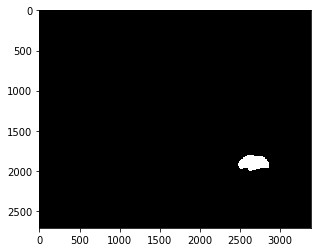

In [45]:
plt.imshow(a*255)

In [18]:
r['masks'][:, :, 0].shape

NameError: name 'r' is not defined

In [47]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

ValueError: a must be non-empty

In [74]:
r["rois"]

array([[ 711,  422,  928,  894],
       [ 685,  826,  748, 1004],
       [ 629,  222,  648,  243],
       [ 647,  507,  679,  569],
       [ 641,  447,  656,  474],
       [ 645,  501,  670,  530],
       [ 643,  503,  654,  530],
       [ 641,  482,  660,  499]], dtype=int32)

In [75]:
r["class_ids"]

array([3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [76]:
r["scores"]

array([0.9969446 , 0.9946017 , 0.992332  , 0.83706295, 0.8179433 ,
       0.81449354, 0.7057352 , 0.7026884 ], dtype=float32)

In [16]:
r

{'class_ids': array([3, 3, 3, 9, 3, 3, 3, 9, 3, 3, 3, 3], dtype=int32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
 

#### Submision File


In [80]:
d = df_test_results.ix[200]
d

ImageId                           24e40595388f15dcaa2a2dee8bcb4d26
LabelId                                                         33
Confidence                                                0.813742
PixelCount                                                       0
EncodedPixels    /home/ubuntu/datalab/test_masks/24e40595388f15...
rois                                         [1710  901 1811 1027]
Name: 200, dtype: object

In [49]:
mask_path = d['EncodedPixels'].split('/')[-1]
mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)

In [50]:
mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]

(98, 113)

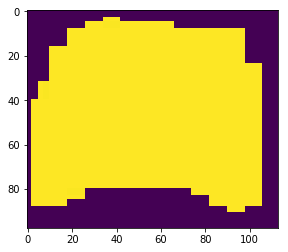

In [52]:
plt.imshow(mask*255)
mask.shape

In [53]:
def find_pixels(mask):
    endcoded_pixels = []
    total_pixels = 0
    for i in range(mask.shape[0]):
        init = 0
        end = 0
        carry = i*mask.shape[1]
        for j in range(1, mask.shape[1]):
            if mask[i, j] > 0 and mask[i, j - 1] == 0:
                init = j + carry

            if mask[i, j] == 0 and mask[i, j - 1] > 0:
                end = j-init + carry
                endcoded_pixels.append( str(init) + ' ' +  str(end) ) 
                total_pixels += end
                init = 0
                end = 0

    return endcoded_pixels, total_pixels

In [54]:
encodp, _ = find_pixels(mask)

In [56]:
"|".join(encodp) + "|"

'373 8|486 8|591 40|704 40|817 40|922 80|1035 80|1148 80|1261 80|1374 80|1487 80|1600 80|1713 80|1818 88|1931 88|2044 88|2157 88|2270 88|2383 88|2496 88|2609 88|2722 96|2835 96|2948 96|3061 96|3174 96|3287 96|3400 96|3513 96|3621 101|3734 101|3847 101|3960 101|4073 101|4186 101|4299 101|4412 101|4522 104|4635 104|4748 104|4861 104|4974 104|5087 104|5200 104|5313 104|5426 104|5539 104|5652 104|5765 104|5878 104|5991 104|6104 104|6217 104|6330 104|6443 104|6556 104|6669 104|6782 104|6895 104|7008 104|7121 104|7234 104|7347 104|7460 104|7573 104|7686 104|7799 104|7912 104|8025 104|8138 104|8251 104|8364 104|8477 104|8590 104|8703 104|8816 104|8929 104|9042 24|9114 32|9155 24|9227 32|9268 24|9340 32|9381 24|9461 24|9494 24|9574 24|9607 16|9687 24|9720 16|9800 24|9833 16|9913 24|10034 8|10147 8|10260 8|'

In [61]:
df_test_results['PixelCount'][3]
df_test_results.shape

(20328, 6)

In [100]:
# for i in range(2):
for i in range(df_test_results.shape[0]):
    d = df_test_results.ix[i]
    mask_path = d['EncodedPixels'].split('/')[-1]
    mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)
    mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
    mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]
    encoded_pixels, pixels_count = find_pixels(mask)
    encoded_pixels = "|".join(encoded_pixels) + "|"
    df_test_results['PixelCount'][i] = pixels_count
    df_test_results['EncodedPixels'][i] = encoded_pixels

TypeError: 'NoneType' object is not subscriptable

In [101]:
df_test_results.head()

,ImageId,LabelId,Confidence,PixelCount,EncodedPixels,rois
0,56dbd8514bd2b8d1566f8977cfeb0406,33,0.999186,280072,3288 72|4031 72|4734 144|5477 144|6220 144|689...,[1911 2476 2425 3219]
1,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998902,16432,884 104|1150 104|1416 104|1682 112|1948 112|22...,[1773 2146 1861 2412]
2,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998630,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1783 2775 1850 2903]
3,56dbd8514bd2b8d1566f8977cfeb0406,33,0.998304,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1791 2936 1881 3078]
4,56dbd8514bd2b8d1566f8977cfeb0406,33,0.993302,0,/home/ubuntu/datalab/test_masks/56dbd8514bd2b8...,[1679 6 1755 197]


In [95]:
def result_function(i):
    d = df_test_results.iloc[i]
    mask_path = d['EncodedPixels'].split('/')[-1]
    mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)
    mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
    mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]
    encoded_pixels, pixels_count = find_pixels(mask)
    encoded_pixels = "|".join(encoded_pixels) + "|"
#     df_test_results['PixelCount'][i] = pixels_count
#     df_test_results['EncodedPixels'][i] = encoded_pixels
#     print(df_test_results.ix[i])
    with open('my_csv.csv', 'a') as f:
        #df_test_results.ix[i].to_csv(f, header=False)
        #pd.DataFrame(df_test_results.iloc[i]).to_csv(f, header=False)
        f.write(str(i) + ',' + str(df_test_results.iloc[i]['ImageId']) + ',' + str(df_test_results.iloc[i]['LabelId']) + ',' + str(df_test_results.iloc[i]['Confidence']) + ',' + str(pixels_count) + ',' + str(encoded_pixels) + ',' + str(df_test_results.iloc[i]['rois']))
        f.write('\n')

In [ ]:
pool = multiprocessing.Pool(8)
zip(pool.map(result_function, range(0, df_test_results.shape[0])))
pool.close()